In [1]:
include("../scripts/ideal_robot.jl")

In [2]:
using Distributions
using Random

In [3]:
mutable struct Robot <: AbstractRobot
    pose
    r
    color
    agent
    poses
    sensor
    noise_pdf
    distance_until_noise
    theta_noise
    bias_rate_nu
    bias_rate_omega
end


In [7]:
function Robot(pose, agent, sensor, color, noise_per_meter = 5, noise_std=pi/60,
    bias_rate_stds=(0.1,0.1))
    rbt = Robot(pose, 0.2, color, agent, [pose],  sensor, nothing, nothing, nothing, nothing, nothing)
    rbt.noise_pdf = Exponential(1.0/(1e-100 + noise_per_meter))
    rbt.distance_until_noise = rand(rbt.noise_pdf)
    rbt.theta_noise = Normal(0, noise_std)
    rbt.bias_rate_nu = rand(Normal(1, bias_rate_stds[1]))
    rbt.bias_rate_omega = rand(Normal(1, bias_rate_stds[2]))
    return rbt
end

Robot

In [10]:
function noise(self::Robot, pose, nu, omega, time_interval)
    self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
    if self.distance_until_noise <= 0.0
        self.distance_until_noise += rand(self.noise_pdf)
        pose[3] += rand(self.theta_noise)
    end
    return pose
end

noise (generic function with 1 method)

In [11]:
function bias(self::Robot, nu, omega)
    return nu*self.bias_rate_nu, omega*self.bias_rate_omega
end

bias (generic function with 1 method)

In [12]:
function one_step(self::Robot, time_interval)
    if isnothing(self.agent)
        return
    end
    obs = nothing
    if !isnothing(self.sensor)
        obs = data(self.sensor, self.pose)
    end
    nu, omega = decision(self.agent, obs)
    nu, omega = bias(self, nu, omega)
    self.pose = state_transition(self, nu, omega, time_interval)
    self.pose = noise(self, self.pose, nu, omega, time_interval)
end

one_step (generic function with 3 methods)

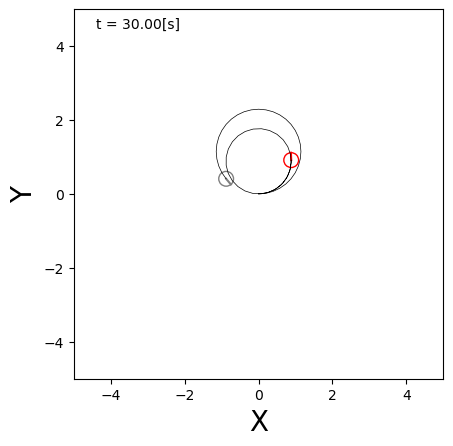

In [19]:
world = World(30, 1.0)
circling = Agent(0.2, 10.0/180*pi)
nobias_robot = IdealRobot([0.0, 0.0, 0.0], circling, nothing, "gray")
append(world, nobias_robot)
biased_robot = Robot([0.0, 0.0, 0.0], circling, nothing, "red", 0,0, (0.2, 0.2) )
append(world, biased_robot)
draw(world)

In [20]:
showanim("test.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAWw1tZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADUtliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5GeJI+w65vIpFM505Ok+93xmUtuVHGQ3eacRH3D3LWgvRa8VlJf0rW/lw3pNMKrLBfC42qBBbPPf9t2q9s/FQBF+eHBqb/CB1m4Za8y+nnzp4tqwGv7FWpgi0iuEQ4W59KBcdz8U2ukqDc8XRyHIGUzQWrN2B2hH41jBxiu8GM2/yYQASZZNk6cnN992hxnRVU/+oJK/JdfpqQC09Qp+0lkF/MADsjxgxnmkyiD4cJFbjyc/bIvgLZswUinp9mbC+OqS+B3Ka9nIBrRd8URZmZnmnn6jGyox4iNCMwrJzVTMejzVjwcpF5gWSDBAd3fPNh4CYMsOqHHJJ1HIr3/3KzKyJnKGIPwD1EjEsKeZY5DEKBN4Lbx26JgmuTA0OP3RbWAeL+irUAAdvximab6tYtmIDtSY3U913HQxRgmhp/597w3yfZ52GLUciYxAXWl/cWNdO3OLelzk/jyowoJf3B3AMMnRPbQ6GhaPpBASX0ILIG7R4/0xLCQjBxlUT3CimqT5DJAljI4vZT82UM1wunjGn3Hzfh2lbCjGasaLTcQv4b+aS7XCO/w2axSSs4uW0UobWYPDfUuyT8lg4T1MK+fgaeXWTf8GHSxwkrUXyj+zIkUpwXcTcZmeS7I9UXZam7aqXAueG9S5hZIexELmsyBs0aviVWZJxN9IslwWdrzqpK6dqgaBFIDrXDoKuKd/AWpVrSr2IQm9mVC+V7PxfVFhkqZNtpKOMUsZPtyuAuF/Fc5RM3OiTM2bNIYvMAEYa5EYzebYqAZd6wKmX6RpLDPX5fXkBZ8Gki6wC88I96CelfK1CsoPZcg60Xm3RqHXw79CW9Hc3ljQzyqM1FQeCC0w497SDwdscJMQQMRotKh7dwqclLLWuigXnd5e/NCeHFhq48CsR0GcvRQPZstbSQEJLNPUfrmiUJNPM4iannsIZlNa8w7qf9s9wTquAFtNpAIYy2mRROyE68IzXj/RRVr1FVhHnsKY9VtQaGOzPivX7xCWnMRfvJ1GoDfN9vYZSuZKqpbXo+gewGoqhXv9Rnx1wvbLs3yPyrEqXEGYj6v64+7ZHfRRGhpB8PwktuVab/sFATV6ej3PtyubkQihNLmZ3w98L+AB8/qpxefxm7+LkafblAz9irmikw9IcfYiefRBx3/IcZBoSSCjG211Pj+wZOiDoBWVZCBE1EJklbn/vWG8HHC4Appafr5A5ViMUEmoUcGD6UXTxDZUIlfh1O2oNYhc6nSqtc0JsG5Jf4U9LrZl7zhuyOK8rzJJs7ziGFbt7DJxYFWMAQMzaOb5XVtMh6De7w87PDP2RJhVSkZtwMnwTLgynvmyCZubNadjlJB7ollvyAp524pGI8J6okcwMko1SONnWqVTgsRITl/HV7HN1+3LlXYX54K6TOVGVmtQqzhKbZMcUSUOokI4ogwAL46LsJ0MPOtUPwsT/jPwRKCIVpq4sgxOytW8WnZQzHWeb9sMtUkkxYb0m5yyi7EP4jjJ7Xj0derVLm3WIQqNRNWS4iofQNkKcltgQ7zGue8TwQiH3joXrm4f23fMHwKBSPan1hG5ueSXWkwPB1/ikGm9N7/2V0mM2WUdx02d/7KCoj7JUF1mbPMf64+Rw04m4+3ENgh/wljpgXKmAlXqmp66maDsy2/7Zzg5Et2h5qgKZWelCgDSByZQegzrKzpkidSB2Q6mROVloZAbgWGrTbSh7AZoMTLPFBGSDsxYVqwFdMX89Uksccs3D/KNs9eq9ZpYFPZZcjmQQyHL+I9OVctpNhSe5OlGq2zy2lHC+mKqdJXmsbECs5NpLaaCTLI8ZhvkvXHUJiVQsmK6L/mHR1TOETzz3O8l3VRFzslAIYNHi+x6zVSJ1KFJWgArUlr2noD9ADY+/QI4ABWBBN6KKKHjy8AX+5TaVFq/dcqX16jmWB//TJ5t0skS5Qflms15xGGd3jRTzkOP1m7wTYDIGMfRaGN6lRINs16wiy+sTj9C5IOUGgzXrdsjAIyQM0laYlu+2g2PxRIJbJHkzObJV4t4N6JAiVaF4E5/z395z1l5OJYW5VzqEglGqwO87Jw03Jfl5BuyutNnKO9+R1xeLuA+YxZqwRgG3KDtKBKwek0/hNOv5R6I9i/UU1M5F9ebASCio1LDy7zrENweYfeMPLb0kAAAAwAAzpz6eKVpz5HG1a95cw/HYlPuu9F6OZcQiQSpaRAorBiFnuYUr/7hBk64Z+CF1bzw22NCyPTDzn+x+nJVBqoj5eFrqmmg1WQpbnNEMEwLBK13vQ4Ajf644DoWrpQzoWh9ZNDvq/ZMPAFH9F4ZOlWN6D/ZP8Ye7OIbthh6kEoUKOdWh6JHUFC4w8k0KX3nflmQ5lvG7x68W+CFpauhPw53X7MK1HlOhxFcIvBqEZ9/2JiAz0LMoAAulM1PUlg